In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('../../dataset/deleted_common_words.xlsx')

In [3]:
df['class'].value_counts().sort_index().index

Index([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 52, 53, 54, 56, 57, 58,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81],
      dtype='int64', name='class')

In [4]:
df = df.reset_index(drop=True)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'])

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [6]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=76, output_attentions=True, output_hidden_states=True)

/opt/jupyterhub/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [8]:
def tokenize_function(description, tokenizer, max_length=512):
    return tokenizer(description.tolist(), padding='max_length', truncation=True, max_length=max_length)

In [9]:
from sklearn.model_selection import train_test_split

X = df['natasha_response_stopwords']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [13]:
X_train_list = X_train.astype(str).tolist()
X_test_list = X_test.astype(str).tolist()

# Define your tokenize function (without the .tolist() call)
def tokenize_function(description, tokenizer, max_length=512):
    return tokenizer(description, padding='max_length', truncation=True, max_length=max_length)

# Tokenize the lists of strings
train_encodings = tokenize_function(X_train_list, tokenizer)
test_encodings = tokenize_function(X_test_list, tokenizer)

In [14]:
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

In [15]:
from torch.utils.data import Dataset, DataLoader

class JobDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = JobDataset(train_encodings, y_train)
test_dataset = JobDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [16]:
from torch.optim import AdamW

In [17]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [18]:
from tqdm import tqdm

def train_model(model, train_loader, test_loader, optimizer, device, num_epochs=5, accumulation_steps=4):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs} - Тренировка", leave=False)

        optimizer.zero_grad()  

        for i, batch in enumerate(train_loader_tqdm):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss / accumulation_steps  
            loss.backward()  
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()  
                optimizer.zero_grad()  

            total_train_loss += loss.item() * accumulation_steps  

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        test_loader_tqdm = tqdm(test_loader, desc=f"Эпоха {epoch+1}/{num_epochs} - Валидация", leave=False)
        with torch.no_grad():
            for batch in test_loader_tqdm:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Эпоха {epoch+1}/{num_epochs} | Тренировочная потеря: {avg_train_loss:.4f} | Валид потеря: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [19]:
train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, device)

Эпоха 1/5 - Тренировка:   0%|          | 0/1691 [00:00<?, ?it/s]BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Эпоха 1/5 | Тренировочная потеря: 3.0137 | Валид потеря: 1.9421


Эпоха 2/5 | Тренировочная потеря: 1.5696 | Валид потеря: 1.3125


Эпоха 3/5 | Тренировочная потеря: 1.1269 | Валид потеря: 1.1567


Эпоха 4/5 | Тренировочная потеря: 0.8864 | Валид потеря: 1.0979


Эпоха 5/5 | Тренировочная потеря: 0.7143 | Валид потеря: 1.0906


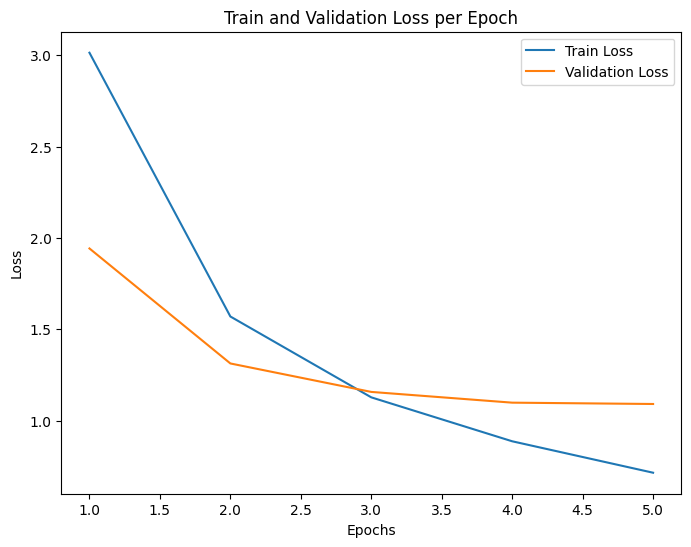

In [20]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Train and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)



In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')  # Используем average='weighted'
    recall = recall_score(all_labels, all_predictions, average='weighted')        # Используем average='weighted'
    f1 = f1_score(all_labels, all_predictions, average='weighted')                # Используем average='weighted'

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

evaluate_model(model, test_loader, device)


Accuracy: 0.6962
Precision: 0.7058
Recall: 0.6962
F1-score: 0.6835


In [22]:
test_data = pd.read_csv('../../dataset/test_data_0_406.csv')

In [24]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import pandas as pd


def tokenize_descriptions(descriptions, tokenizer, max_length=512):
    return tokenizer(descriptions.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")

encodings = tokenize_descriptions(test_data['clean_description'], tokenizer)

class DescriptionDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

description_dataset = DescriptionDataset(encodings)
description_loader = DataLoader(description_dataset, batch_size=16, shuffle=False)

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Предсказания"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            probs = F.softmax(logits, dim=-1)
            
            predicted_classes = torch.argmax(probs, dim=-1)
            
            predictions.extend(predicted_classes.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    return predictions, probabilities

predicted_classes, predicted_probabilities = predict(model, description_loader, device)

test_data['predicted_class'] = predicted_classes
test_data['predicted_probability'] = [max(prob) for prob in predicted_probabilities]


Предсказания: 100%|██████████| 4343/4343 [32:09<00:00,  2.25it/s]


In [26]:
sample = test_data.groupby(['predicted_class']).mean('predicted_probability')

In [27]:
sample.to_excel('dfd.xlsx')